In [40]:
pip install pandas numpy matplotlib scikit-learn wfdb

Sample Metadata:
   ecg_id  patient_id   age  sex  height  weight  nurse  site     device  \
0       1     15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
1       2     13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
2       3     20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
3       4     17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
4       5     17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

        recording_date  ... validated_by_human  baseline_drift static_noise  \
0  1984-11-09 09:17:34  ...               True             NaN    , I-V1,     
1  1984-11-14 12:55:37  ...               True             NaN          NaN   
2  1984-11-15 12:49:10  ...               True             NaN          NaN   
3  1984-11-15 13:44:57  ...               True    , II,III,AVF          NaN   
4  1984-11-17 10:43:15  ...               True   , III,AVR,AVF          NaN   

  burst_noise electrodes_problems  extra_beats  pac

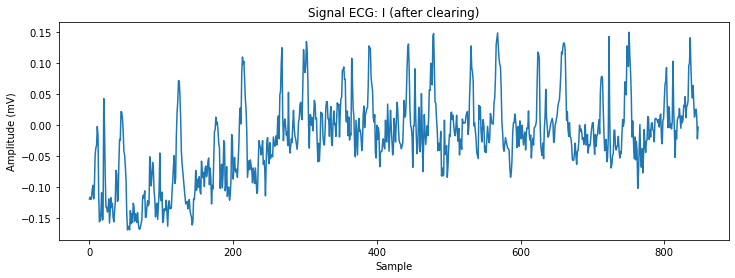

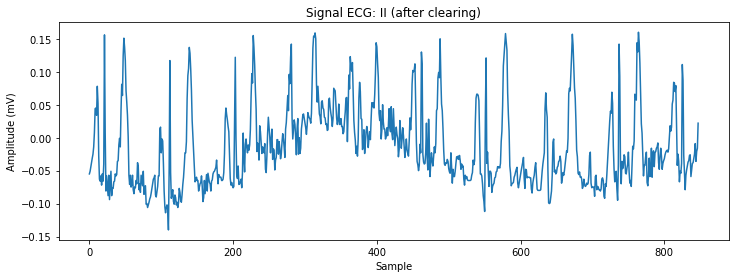

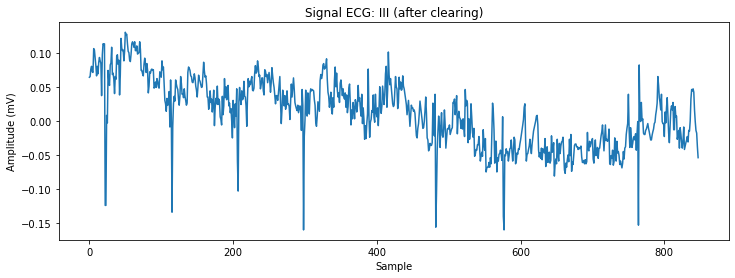

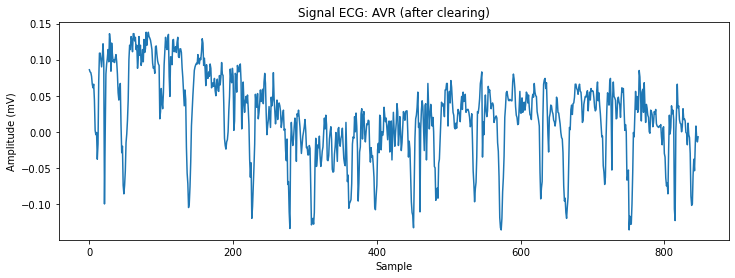

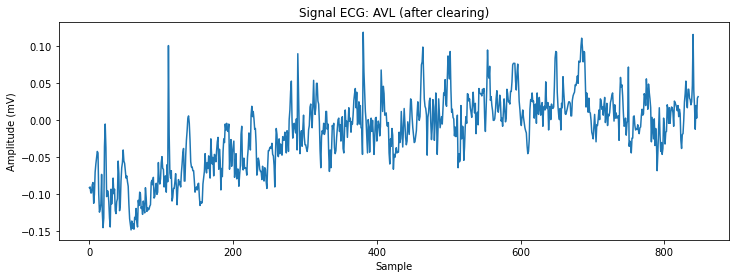

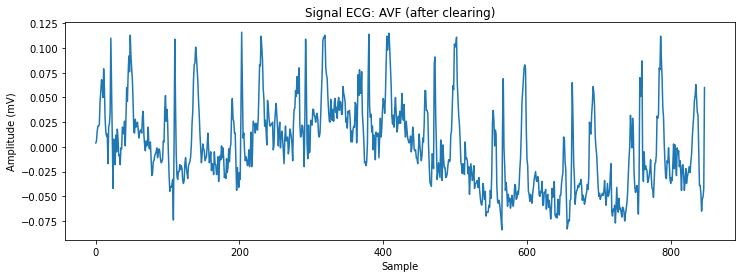

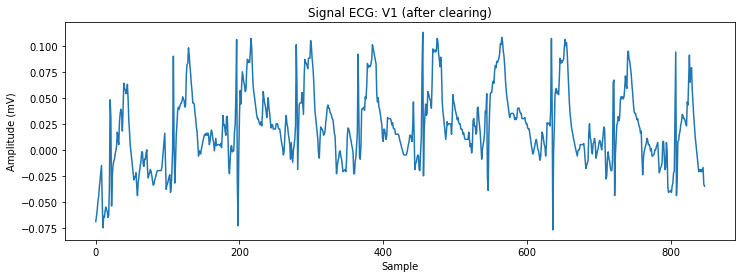

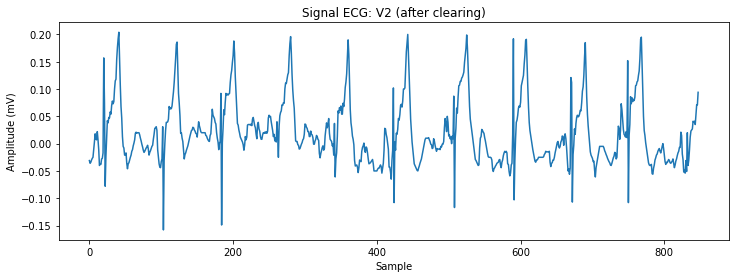

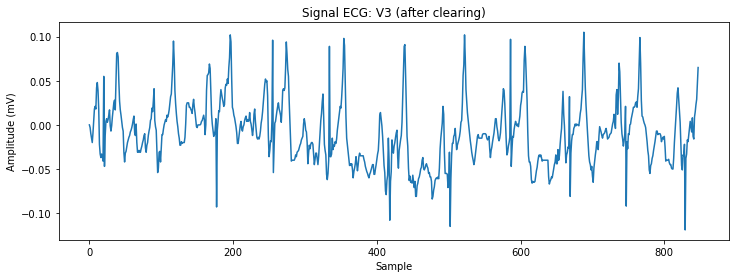

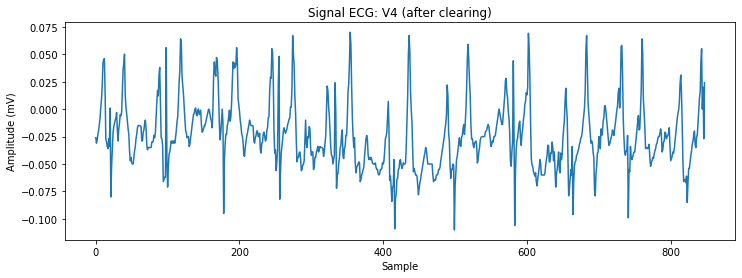

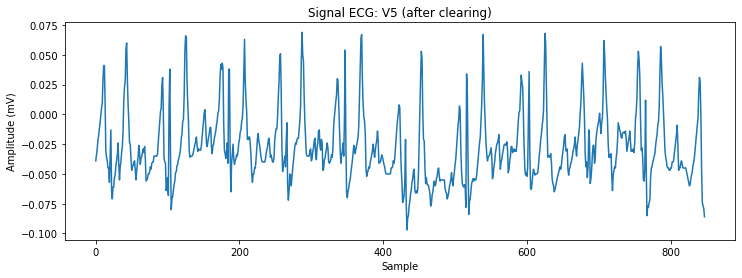

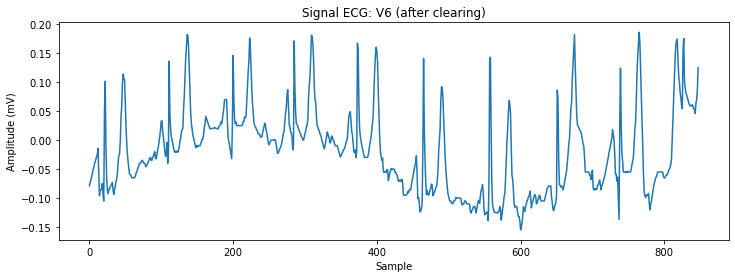

In [1]:
import os
import wfdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Path to the data folder
data_folder_path = r'C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

# Paths to the recording folders
records100_path = os.path.join(data_folder_path, 'records100')
records500_path = os.path.join(data_folder_path, 'records500')

# Load metadata
metadata_path = os.path.join(data_folder_path, 'ptbxl_database.csv')
metadata_df = pd.read_csv(metadata_path)

# Display the first few rows of metadata
print("Sample Metadata:")
print(metadata_df.head())

# Function for identifying and removing outliers in signals
def remove_outliers(signal, threshold=1.5):
    Q1 = np.percentile(signal, 25, axis=0)
    Q3 = np.percentile(signal, 75, axis=0)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - (IQR * threshold)
    upper_bound = Q3 + (IQR * threshold)
    
    mask = (signal >= lower_bound) & (signal <= upper_bound)
    signal_cleaned = signal[mask]
    
    return signal_cleaned

# Function for loading, cleaning, and displaying ECG signals
def load_and_plot_record(folder_path, subfolder, record_name):
    record_path = os.path.join(folder_path, subfolder, record_name)
    record_dat_path = record_path + '.dat'
    record_hea_path = record_path + '.hea'

    if not os.path.isfile(record_dat_path):
        print(f"Record file does not exist: {record_dat_path}")
        return
    if not os.path.isfile(record_hea_path):
        print(f"Header file does not exist: {record_hea_path}")
        return
    
    try:
        # Load ECG record
        record = wfdb.rdrecord(record_path, channels=[0,1,2,3,4,5,6,7,8,9,10,11])
        print(f"Record Name: {record.record_name}")
        print(f"Number of Signals: {record.n_sig}")
        print(f"Sampling Frequency: {record.fs} Hz")
        print(f"Signal Length: {record.sig_len}")

        # Cleaning signals from outlier values
        cleaned_signals = []
        for i in range(record.n_sig):
            cleaned_signal = remove_outliers(record.p_signal[:, i])
            if cleaned_signal.size > 0:
                cleaned_signals.append(cleaned_signal)
        
        # Check if there are signals to display
        if len(cleaned_signals) == 0:
            print(f"No valid signals found after outlier removal for record {record_name}.")
            return
        
        # Trimming signals to the length of the shortest signal
        min_length = min(signal.size for signal in cleaned_signals)
        cleaned_signals = [signal[:min_length] for signal in cleaned_signals]
        
        # Convert signals from a list to a NumPy array
        p_signal_cleaned = np.column_stack(cleaned_signals)
        
        # Displaying ECG signals after cleaning
        for i in range(p_signal_cleaned.shape[1]):
            plt.figure(figsize=(12, 4))
            plt.plot(p_signal_cleaned[:, i])
            plt.title(f'Signal ECG: {record.sig_name[i]} (after clearing)')
            plt.xlabel('Sample')
            plt.ylabel('Amplitude (mV)')
            plt.show()
    
    except Exception as e:
        print(f"An error occurred while loading or plotting the record: {e}")

# Example: Load, clean, and display the first record from records100/00000
load_and_plot_record(records100_path, '00000', '00001_lr')



In [2]:
def check_missing_values_in_signals(record):
    has_missing_values = np.isnan(record.p_signal).any()
    if has_missing_values:
        print("Missing values (NaN) found in ECG data!")
    else:
        print("No missing values in ECG data.")

# Example: Check first record
record_example = wfdb.rdrecord(os.path.join(records100_path, '00000', '00001_lr'), channels=[0,1,2,3,4,5,6,7,8,9,10,11])
check_missing_values_in_signals(record_example)

No missing values in ECG data.


In [3]:
# Function to check for missing values in the signal
def check_missing_values_in_signals(record):
    has_missing_values = np.isnan(record.p_signal).any()
    if has_missing_values:
        print(f"Empty values (NaN) found in ECG data! Record: {record.record_name}")

# Iterate through all subfolders and files in records100
for subfolder in os.listdir(records100_path):
    subfolder_path = os.path.join(records100_path, subfolder)
    
    if os.path.isdir(subfolder_path):
        for record_file in os.listdir(subfolder_path):
            # Record files without extensions
            record_name = record_file.split('.')[0]
            record_path = os.path.join(subfolder_path, record_name)

            # Check if the .dat file exists (to ensure it is a complete record)
            if os.path.exists(record_path + '.dat'):
                # load record
                record = wfdb.rdrecord(record_path, channels=[0,1,2,3,4,5,6,7,8,9,10,11])
                
                # Check for missing values
                check_missing_values_in_signals(record)



In [43]:
#What are the atributes of metadata?
metadata_df.columns

Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr'],
      dtype='object')

In [44]:
#We are looking for something related to assessing its health status
print(metadata_df['scp_codes'].head())

0    {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
1                {'NORM': 80.0, 'SBRAD': 0.0}
2                  {'NORM': 100.0, 'SR': 0.0}
3                  {'NORM': 100.0, 'SR': 0.0}
4                  {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, dtype: object


In [45]:
#Classification of health conditions based on ECG signals
import os
import wfdb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Ścieżka do folderu z danymi
data_folder_path = r'C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'
records100_path = os.path.join(data_folder_path, 'records100')

# Wczytaj metadane
metadata_path = os.path.join(data_folder_path, 'ptbxl_database.csv')
metadata_df = pd.read_csv(metadata_path)

# Konwersja scp_codes i tworzenie kolumny diagnosis
import ast

metadata_df['scp_codes'] = metadata_df['scp_codes'].apply(ast.literal_eval)

scp_to_diagnosis = {
    'NORM': 'healthy',
    'MI': 'heart attack',
    'STTC': 'ST-T changes',
    'CD': 'chronic heart disease',
    'HYP': 'hypertrophy',
    'ARR': 'arrhythmia',
    'SR': 'sinus rhythm',
    'SBRAD': 'bradycardia',
    'LVOLT': 'low voltage'
}

def map_scp_to_diagnosis_weighted(scp_codes):
    max_weight = 0
    diagnosis = 'other'
    
    for scp_code, weight in scp_codes.items():
        if scp_code in scp_to_diagnosis and weight > max_weight:
            diagnosis = scp_to_diagnosis[scp_code]
            max_weight = weight
            
    return diagnosis

metadata_df['diagnosis'] = metadata_df['scp_codes'].apply(map_scp_to_diagnosis_weighted)

# Wczytanie i czyszczenie sygnałów EKG
def remove_outliers(signal):
    mean = np.mean(signal)
    std_dev = np.std(signal)
    return signal[np.abs(signal - mean) < 3 * std_dev]

def load_and_clean_record(file_path):
    record_dat_path = file_path + '.dat'
    record_hea_path = file_path + '.hea'

    if not os.path.isfile(record_dat_path):
        print(f"File not found: {record_dat_path}")
        return None
    if not os.path.isfile(record_hea_path):
        print(f"File not found: {record_hea_path}")
        return None
    
    try:
        record = wfdb.rdrecord(file_path, channels=[0,1,2,3,4,5,6,7,8,9,10,11])
        cleaned_signals = []
        for i in range(record.n_sig):
            cleaned_signal = remove_outliers(record.p_signal[:, i])
            if cleaned_signal.size > 0:
                cleaned_signals.append(cleaned_signal)
                
        if len(cleaned_signals) == 0:
            return None
        
        min_length = min(signal.size for signal in cleaned_signals)
        cleaned_signals = [signal[:min_length] for signal in cleaned_signals]
        
        p_signal_cleaned = np.column_stack(cleaned_signals)
        return p_signal_cleaned
    
    except Exception as e:
        print(f"Error loading record: {e}")
        return None

# Preparing data for modeling
def prepare_data_for_model(metadata_df, folder_path):
    X = []
    y = []

    for index, row in metadata_df.iterrows():
        record_name = row['filename_lr']
        diagnosis = row['diagnosis']
        
        # Constructing the full path to the file
        file_path = os.path.join(folder_path, os.path.splitext(record_name)[0])
        
        # Debugging: displaying the full path
        print(f"Trying to load file: {file_path}")
        
        signal = load_and_clean_record(file_path)
        if signal is not None:
            X.append(signal.flatten())  # Flatten to create a single feature vector
            y.append(diagnosis)
    
    return np.array(X), np.array(y)

# Preparing data
X, y = prepare_data_for_model(metadata_df, records100_path)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalization of data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluation of model
y_pred = model.predict(X_test_scaled)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00001_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00001_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00002_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00002_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00003_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a

Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00125_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00125_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00126_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00126_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00127_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a

File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00225_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00226_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00226_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00227_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00227_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-

File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00298_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00299_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00299_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00300_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00300_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-

File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00422_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00423_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00423_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00424_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00424_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-

File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00528_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00529_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00529_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00530_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00530_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-

File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00597_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00598_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00598_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00599_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00599_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-

File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00731_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00732_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00732_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00733_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00733_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-

File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00827_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00828_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00828_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00829_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00829_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-

File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00922_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00923_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00923_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00924_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00924_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-

File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00993_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00994_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00994_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00995_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/00000/00995_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-

File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01084_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01085_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01085_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01086_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01086_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-

File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01176_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01177_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01177_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01178_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01178_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-

Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01249_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01249_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01250_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01250_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01251_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a

File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01314_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01315_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01315_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01316_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01316_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-

File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01392_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01393_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01393_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01394_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01394_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-

Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01480_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01480_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01481_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01481_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01482_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a

File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01583_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01584_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01584_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01585_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01585_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-

File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01677_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01678_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01678_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01679_lr
File not found: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\records100/01000/01679_lr.dat
Trying to load file: C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-

KeyboardInterrupt: 

Sample Metadata:
   ecg_id  patient_id   age  sex  height  weight  nurse  site     device  \
0       1     15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
1       2     13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
2       3     20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
3       4     17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
4       5     17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

        recording_date  ... validated_by_human  baseline_drift static_noise  \
0  1984-11-09 09:17:34  ...               True             NaN    , I-V1,     
1  1984-11-14 12:55:37  ...               True             NaN          NaN   
2  1984-11-15 12:49:10  ...               True             NaN          NaN   
3  1984-11-15 13:44:57  ...               True    , II,III,AVF          NaN   
4  1984-11-17 10:43:15  ...               True   , III,AVR,AVF          NaN   

  burst_noise electrodes_problems  extra_beats  pac

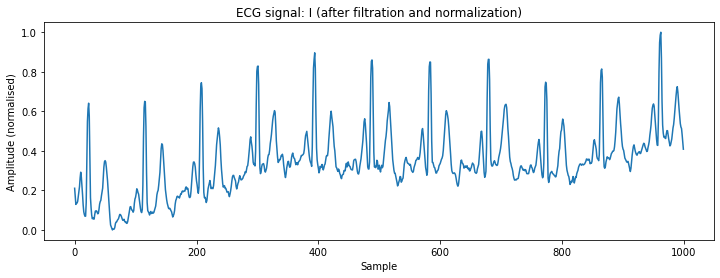

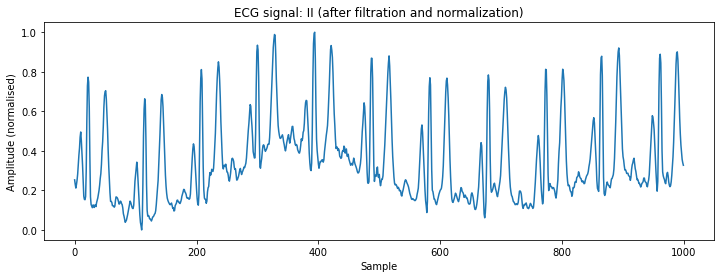

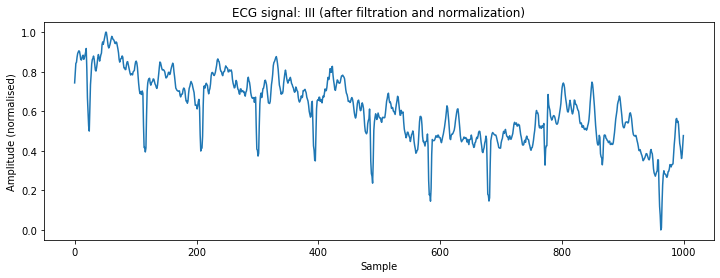

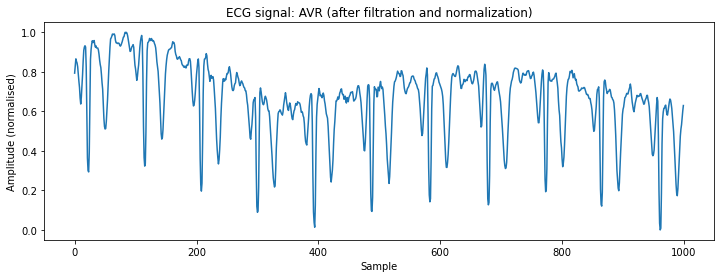

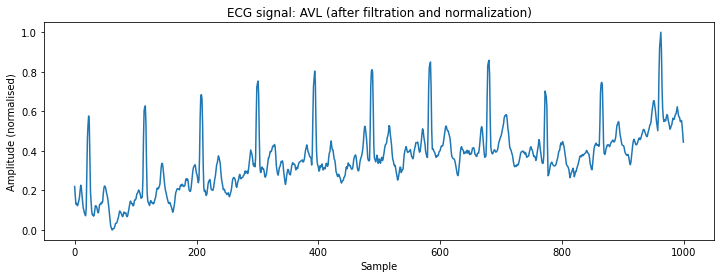

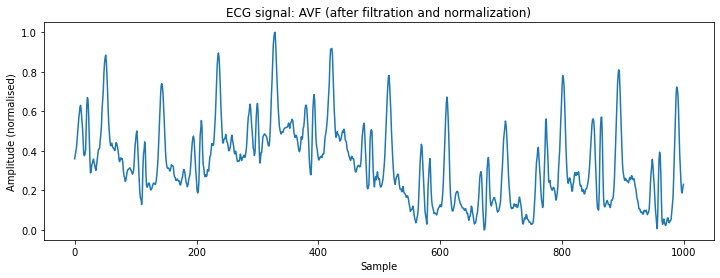

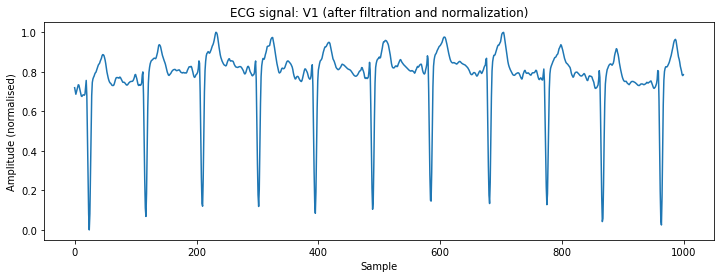

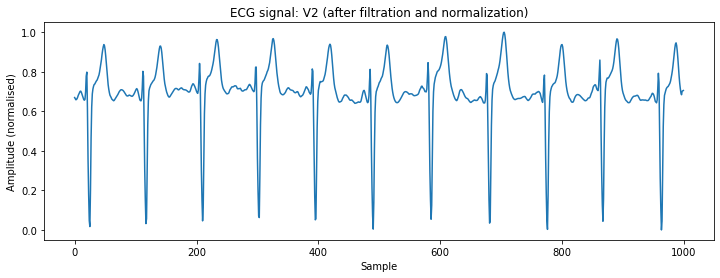

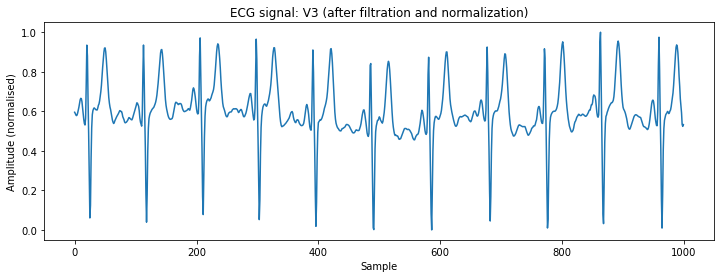

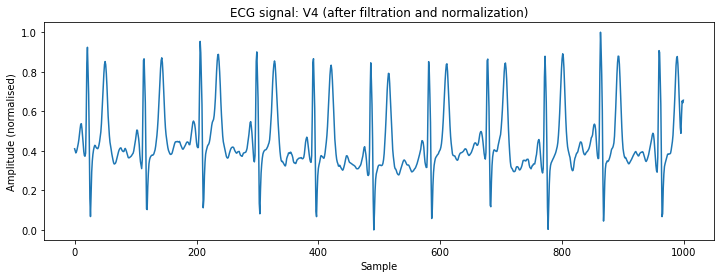

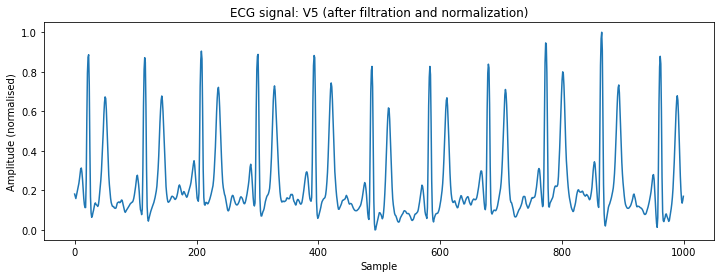

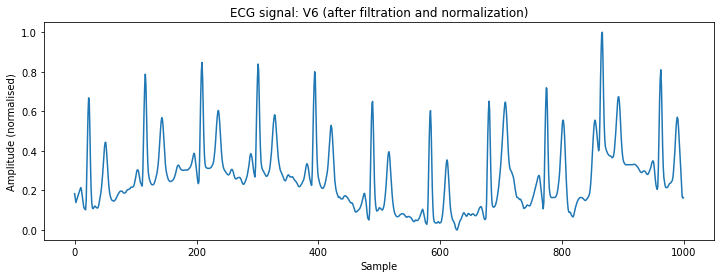

In [1]:
# Noise filtering
import os
import wfdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Path to the data folder
data_folder_path = r'C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

# Paths to the recording folders
records100_path = os.path.join(data_folder_path, 'records100')
records500_path = os.path.join(data_folder_path, 'records500')

# load metadata
metadata_path = os.path.join(data_folder_path, 'ptbxl_database.csv')
metadata_df = pd.read_csv(metadata_path)

# display few first metadata
print("Sample Metadata:")
print(metadata_df.head())

# Function for applying a moving average filter
def moving_average(signal, window_size=5):
    """Zastosowanie filtracji średnią ruchomą do wygładzenia sygnału."""
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')

# Funkcja to normalize signal
def normalize_signal(signal):
    """Normalizacja sygnału do zakresu [0, 1]."""
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

# Function for loading, cleaning, and displaying ECG signals
def load_and_plot_record(folder_path, subfolder, record_name):
    record_path = os.path.join(folder_path, subfolder, record_name)
    record_dat_path = record_path + '.dat'
    record_hea_path = record_path + '.hea'

    if not os.path.isfile(record_dat_path):
        print(f"Record file does not exist: {record_dat_path}")
        return
    if not os.path.isfile(record_hea_path):
        print(f"Header file does not exist: {record_hea_path}")
        return
    
    try:
        # Load ECK record
        record = wfdb.rdrecord(record_path, channels=[0,1,2,3,4,5,6,7,8,9,10,11])
        print(f"Record Name: {record.record_name}")
        print(f"Number of Signals: {record.n_sig}")
        print(f"Sampling Frequency: {record.fs} Hz")
        print(f"Signal Length: {record.sig_len}")

        # Cleaning signals: moving average filtering and normalization
        processed_signals = []
        for i in range(record.n_sig):
            signal_data = record.p_signal[:, i]
            # Filtracja średnią ruchomą
            smoothed_signal = moving_average(signal_data, window_size=5)
            # Normalizacja sygnału
            normalized_signal = normalize_signal(smoothed_signal)
            if normalized_signal.size > 0:
                processed_signals.append(normalized_signal)
        
        # Check if there are signals to display
        if len(processed_signals) == 0:
            print(f"No valid signals found after processing for record {record_name}.")
            return
        
        # Trimming signals to the length of the shortest signal
        min_length = min(signal.size for signal in processed_signals)
        processed_signals = [signal[:min_length] for signal in processed_signals]
        
        # Convert signals from a list to a NumPy array
        p_signal_processed = np.column_stack(processed_signals)
        
        # Displaying ECG signals after filtering and normalization
        for i in range(p_signal_processed.shape[1]):
            plt.figure(figsize=(12, 4))
            plt.plot(p_signal_processed[:, i])
            plt.title(f'ECG signal: {record.sig_name[i]} (after filtration and normalization)')
            plt.xlabel('Sample')
            plt.ylabel('Amplitude (normalised)')
            plt.show()
    
    except Exception as e:
        print(f"An error occurred while loading or plotting the record: {e}")

# Example: Load, clean, and display the first record from records100/00000
load_and_plot_record(records100_path, '00000', '00001_lr')



Sample Metadata:
   ecg_id  patient_id   age  sex  height  weight  nurse  site     device  \
0       1     15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
1       2     13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
2       3     20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
3       4     17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
4       5     17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

        recording_date  ... validated_by_human  baseline_drift static_noise  \
0  1984-11-09 09:17:34  ...               True             NaN    , I-V1,     
1  1984-11-14 12:55:37  ...               True             NaN          NaN   
2  1984-11-15 12:49:10  ...               True             NaN          NaN   
3  1984-11-15 13:44:57  ...               True    , II,III,AVF          NaN   
4  1984-11-17 10:43:15  ...               True   , III,AVR,AVF          NaN   

  burst_noise electrodes_problems  extra_beats  pac

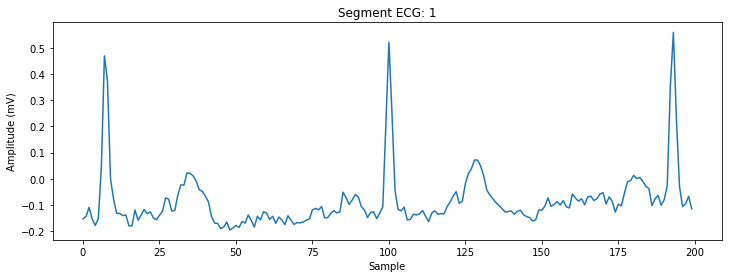

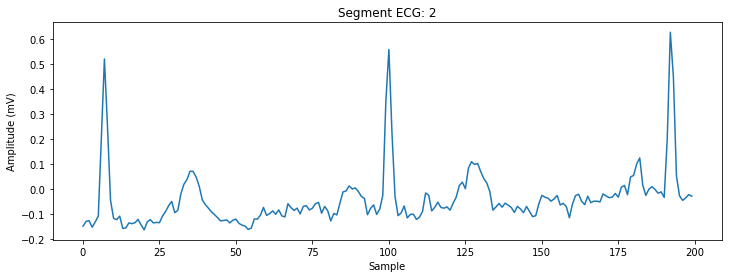

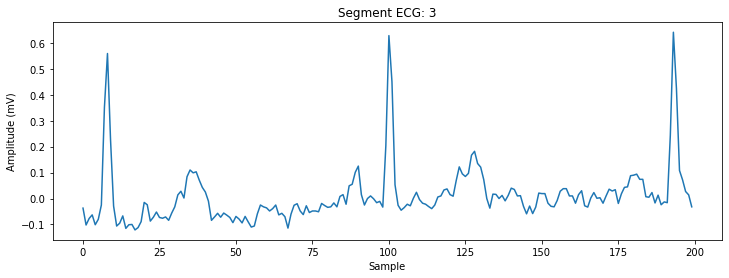

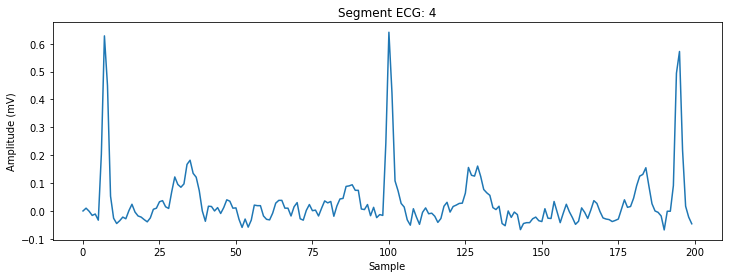

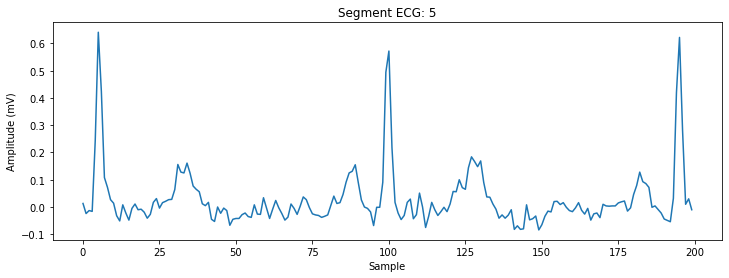

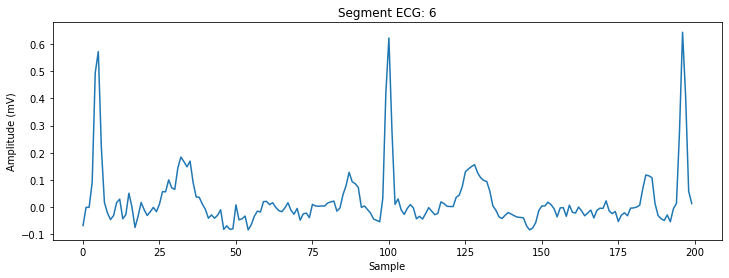

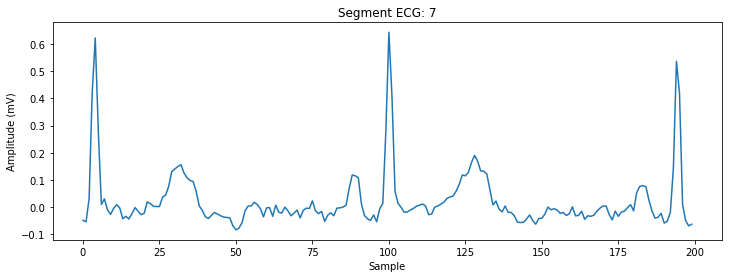

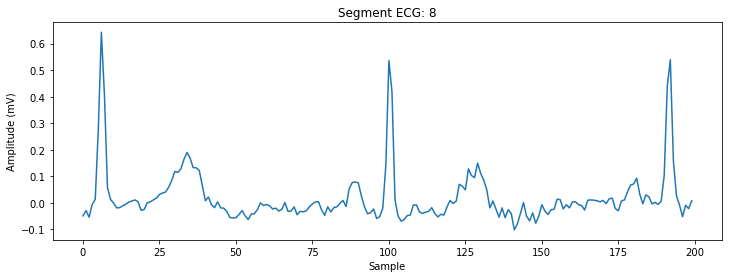

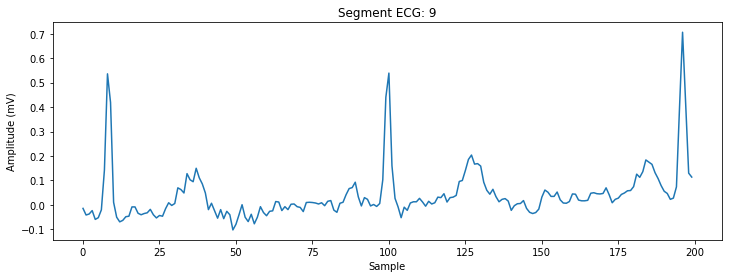

In [2]:
#sagmentacja sygnalow EKG
import os
import wfdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Ścieżka do folderu z danymi
data_folder_path = r'C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

# Ścieżki do folderów z nagraniami
records100_path = os.path.join(data_folder_path, 'records100')
records500_path = os.path.join(data_folder_path, 'records500')

# Load metadata
metadata_path = os.path.join(data_folder_path, 'ptbxl_database.csv')
metadata_df = pd.read_csv(metadata_path)

# Display 5 first metadata
print("Sample Metadata:")
print(metadata_df.head())

# function for R-peaks detection
def detect_r_peaks(signal, sampling_rate=100):
    """Detekcja załamków R w sygnale EKG przy użyciu funkcji find_peaks."""
    # Normalization of a signal
    normalized_signal = (signal - np.mean(signal)) / np.std(signal)
    # Detekcja załamków R
    peaks, _ = find_peaks(normalized_signal, distance=sampling_rate/2.5, height=0.5)#scipy.signal.find_peaks, second variable isnt important for us in this case
    return peaks #peaks is numpy array, containing indexes of signals

# Funkcja do segmentacji sygnału EKG na cykle serca
def segment_signal(signal, r_peaks, window_size=100):
    """Segmentacja sygnału EKG na cykle serca wokół załamków R."""
    segments = []
    for i in range(len(r_peaks) - 1):
        start = r_peaks[i] - window_size // 2
        end = r_peaks[i] + window_size // 2
        if start >= 0 and end < len(signal):
            segment = signal[start:end]
            segments.append(segment)
    return segments

# Funkcja do wczytywania, segmentacji i wyświetlania sygnałów EKG
def load_segment_and_plot_record(folder_path, subfolder, record_name):
    record_path = os.path.join(folder_path, subfolder, record_name)
    record_dat_path = record_path + '.dat'
    record_hea_path = record_path + '.hea'

    if not os.path.isfile(record_dat_path):
        print(f"Record file does not exist: {record_dat_path}")
        return
    if not os.path.isfile(record_hea_path):
        print(f"Header file does not exist: {record_hea_path}")
        return
    
    try:
        # Wczytaj rekord EKG
        record = wfdb.rdrecord(record_path, channels=[0])
        print(f"Record Name: {record.record_name}")
        print(f"Number of Signals: {record.n_sig}")
        print(f"Sampling Frequency: {record.fs} Hz")
        print(f"Signal Length: {record.sig_len}")

        # Detekcja załamków R
        r_peaks = detect_r_peaks(record.p_signal[:, 0], sampling_rate=record.fs)
        
        if len(r_peaks) == 0:
            print("No R peaks detected.")
            return

        # Segmentacja sygnału na cykle serca
        segments = segment_signal(record.p_signal[:, 0], r_peaks, window_size=200)#you can in/decrease window_size value if needed
        
        if len(segments) == 0:
            print("No segments found.")
            return
        
        # Wyświetlanie segmentów EKG
        for i, segment in enumerate(segments):
            plt.figure(figsize=(12, 4))
            plt.plot(segment)
            plt.title(f'Segment ECG: {i + 1}')
            plt.xlabel('Sample')
            plt.ylabel('Amplitude (mV)')
            plt.show()
    
    except Exception as e:
        print(f"An error occurred while loading, segmenting or plotting the record: {e}")

# Przykład: Wczytaj, segmentuj i wyświetl pierwszy rekord z records100/00000
load_segment_and_plot_record(records100_path, '00000', '00001_lr')

Sample Metadata:
   ecg_id  patient_id   age  sex  height  weight  nurse  site     device  \
0       1     15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
1       2     13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
2       3     20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
3       4     17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
4       5     17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

        recording_date  ... validated_by_human  baseline_drift static_noise  \
0  1984-11-09 09:17:34  ...               True             NaN    , I-V1,     
1  1984-11-14 12:55:37  ...               True             NaN          NaN   
2  1984-11-15 12:49:10  ...               True             NaN          NaN   
3  1984-11-15 13:44:57  ...               True    , II,III,AVF          NaN   
4  1984-11-17 10:43:15  ...               True   , III,AVR,AVF          NaN   

  burst_noise electrodes_problems  extra_beats  pac

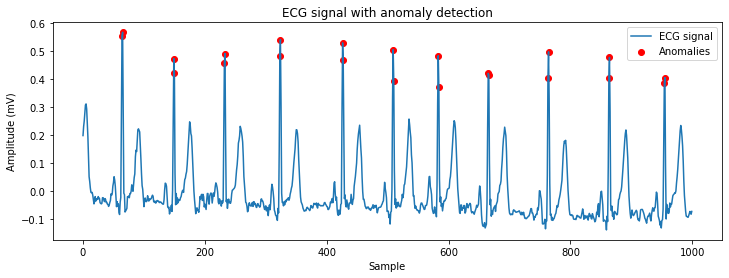

In [1]:
#detekcja anomalii sygnałów EKG
import os
import wfdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Ścieżka do folderu z danymi
data_folder_path = r'C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

# Ścieżki do folderów z nagraniami
records100_path = os.path.join(data_folder_path, 'records100')
records500_path = os.path.join(data_folder_path, 'records500')

# Wczytaj metadane
metadata_path = os.path.join(data_folder_path, 'ptbxl_database.csv')
metadata_df = pd.read_csv(metadata_path)

# Wyświetl kilka pierwszych wierszy metadanych
print("Sample Metadata:")
print(metadata_df.head())

# Funkcja do detekcji załamków R
def detect_r_peaks(signal, sampling_rate=100):
    """Detekcja załamków R w sygnale EKG przy użyciu funkcji find_peaks."""
    normalized_signal = (signal - np.mean(signal)) / np.std(signal)
    peaks, _ = find_peaks(normalized_signal, distance=sampling_rate/2.5, height=0.5)
    return peaks

# Funkcja do detekcji anomalii w sygnale
def detect_anomalies(signal, threshold=3):
    """Detekcja anomalii na podstawie odchyleń standardowych."""
    mean = np.mean(signal)
    std_dev = np.std(signal)
    anomalies = np.where(np.abs(signal - mean) > threshold * std_dev)[0]
    return anomalies

# Funkcja do wczytywania, detekcji anomalii i wyświetlania sygnałów EKG
def load_detect_and_plot_record(folder_path, subfolder, record_name):
    record_path = os.path.join(folder_path, subfolder, record_name)
    record_dat_path = record_path + '.dat'
    record_hea_path = record_path + '.hea'

    if not os.path.isfile(record_dat_path):
        print(f"Record file does not exist: {record_dat_path}")
        return
    if not os.path.isfile(record_hea_path):
        print(f"Header file does not exist: {record_hea_path}")
        return
    
    try:
        # Wczytaj rekord EKG
        record = wfdb.rdrecord(record_path, channels=[0])
        print(f"Record Name: {record.record_name}")
        print(f"Number of Signals: {record.n_sig}")
        print(f"Sampling Frequency: {record.fs} Hz")
        print(f"Signal Length: {record.sig_len}")

        # Detekcja załamków R
        r_peaks = detect_r_peaks(record.p_signal[:, 0], sampling_rate=record.fs)
        
        if len(r_peaks) == 0:
            print("No R peaks detected.")
            return
        
        # Detekcja anomalii
        anomalies = detect_anomalies(record.p_signal[:, 0])
        
        # Wyświetlanie sygnału EKG z zaznaczonymi anomaliami
        plt.figure(figsize=(12, 4))
        plt.plot(record.p_signal[:, 0], label='ECG signal')
        plt.scatter(anomalies, record.p_signal[anomalies, 0], color='red', label='Anomalies')
        plt.title('ECG signal with anomaly detection')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude (mV)')
        plt.legend()
        plt.show()
    
    except Exception as e:
        print(f"An error occurred while loading, detecting anomalies or plotting the record: {e}")

# Przykład: Wczytaj, detekcja anomalii i wyświetl pierwszy rekord z records100/00000
load_detect_and_plot_record(records100_path, '00000', '00011_lr')


In [19]:
from scipy.signal import find_peaks

Record Name: 00001_lr
Number of Signals: 1
Sampling Frequency: 100 Hz
Signal Length: 1000
Extracted RR Intervals Features:
mean_rr_interval: 0.8536363636363635
std_rr_interval: 0.1770091280272254
num_r_peaks: 12


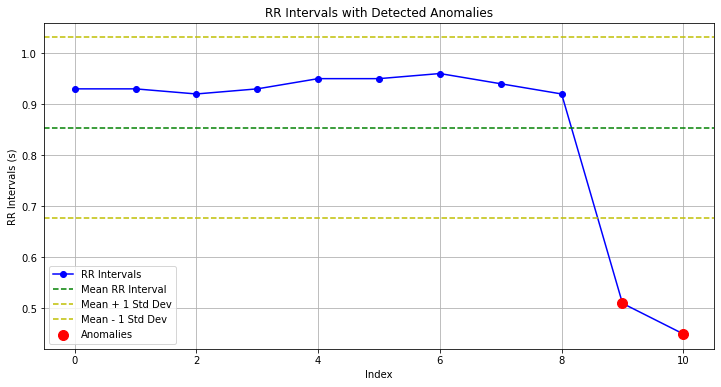

In [30]:
#ekstrakcja cech sygnalów i ich anomalie
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# Ścieżka do folderu z danymi
data_folder_path = r'C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

# Ścieżki do folderów z nagraniami
records100_path = os.path.join(data_folder_path, 'records100')
records500_path = os.path.join(data_folder_path, 'records500')

# Funkcja do detekcji załamków R
def detect_r_peaks(signal, sampling_rate=100):
    """Detekcja załamków R w sygnale EKG przy użyciu funkcji find_peaks."""
    normalized_signal = (signal - np.mean(signal)) / np.std(signal)
    peaks, _ = find_peaks(normalized_signal, distance=sampling_rate/2.5, height=0.5)
    return peaks

# Funkcja do ekstrakcji cech sygnału EKG (odstępy RR)
def extract_rr_intervals(signal, sampling_rate=100):
    """Ekstrakcja odstępów RR z sygnału EKG."""
    r_peaks = detect_r_peaks(signal, sampling_rate=sampling_rate)
    
    if len(r_peaks) < 2:
        print("Not enough R peaks detected to extract RR intervals.")
        return {}, []

    rr_intervals = np.diff(r_peaks) / sampling_rate
    
    features = {
        "mean_rr_interval": np.mean(rr_intervals),
        "std_rr_interval": np.std(rr_intervals),
        "num_r_peaks": len(r_peaks)
    }
    
    return features, rr_intervals

# Funkcja do detekcji anomalii w odstępach RR
def detect_anomalies(rr_intervals, threshold=1):
    """Detekcja anomalii w odstępach RR na podstawie odchylenia standardowego."""
    mean_rr = np.mean(rr_intervals)
    std_rr = np.std(rr_intervals)
    
    anomalies = np.abs(rr_intervals - mean_rr) > threshold * std_rr
    
    return anomalies, mean_rr, std_rr

# Funkcja do wczytywania, ekstrakcji cech i detekcji anomalii
def load_extract_and_detect_anomalies(folder_path, subfolder, record_name):
    record_path = os.path.join(folder_path, subfolder, record_name)
    record_dat_path = record_path + '.dat'
    record_hea_path = record_path + '.hea'

    if not os.path.isfile(record_dat_path):
        print(f"Record file does not exist: {record_dat_path}")
        return
    if not os.path.isfile(record_hea_path):
        print(f"Header file does not exist: {record_hea_path}")
        return
    
    try:
        # Load ECG record
        record = wfdb.rdrecord(record_path, channels=[0])
        print(f"Record Name: {record.record_name}")
        print(f"Number of Signals: {record.n_sig}")
        print(f"Sampling Frequency: {record.fs} Hz")
        print(f"Signal Length: {record.sig_len}")

        # RR Interval Extraction
        features, rr_intervals = extract_rr_intervals(record.p_signal[:, 0], sampling_rate=record.fs)
        
        # Feature Display
        print(f"Extracted RR Intervals Features:")
        for feature, value in features.items():
            print(f"{feature}: {value}")

        # Anomaly detection
        anomalies, mean_rr, std_rr = detect_anomalies(rr_intervals)
        anomaly_indices = np.where(anomalies)[0]
        
        # Plotting anomalies with more visible markers
        plt.figure(figsize=(12, 6))
        plt.plot(rr_intervals, marker='o', linestyle='-', color='b', label='RR Intervals')
        plt.scatter(anomaly_indices, rr_intervals[anomaly_indices], color='r', s=100, label='Anomalies', zorder=5)
        plt.axhline(mean_rr, color='g', linestyle='--', label='Mean RR Interval')
        plt.axhline(mean_rr + std_rr, color='y', linestyle='--', label='Mean + 1 Std Dev')
        plt.axhline(mean_rr - std_rr, color='y', linestyle='--', label='Mean - 1 Std Dev')
        plt.title('RR Intervals with Detected Anomalies')
        plt.xlabel('Index')
        plt.ylabel('RR Intervals (s)')
        plt.legend()
        plt.grid(True)
        plt.show()

    
    except Exception as e:
        print(f"An error occurred while loading or extracting features from the record: {e}")

# Przykład: Wczytaj, ekstrakcja cech i detekcja anomalii z pierwszego rekordu z records100/00000
load_extract_and_detect_anomalies(records100_path, '00000', '00001_lr')



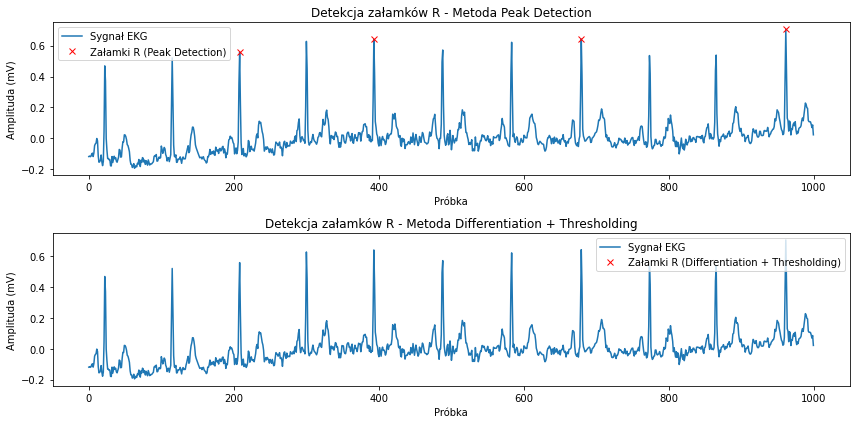

In [1]:
#porównanie skutecznosci algorytmow detekcji sygnalow
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Funkcja do detekcji załamków R za pomocą prostego wykrywania szczytów
def detect_r_peaks(signal, distance=150, height=3):
    peaks, _ = find_peaks(signal, distance=distance, height=height)
    return peaks

# Funkcja do różniczkowania sygnału
def differentiate_signal(signal):
    diff_signal = np.diff(signal)
    return np.concatenate([[0], diff_signal])  # Dopasowanie długości sygnału

# Funkcja do detekcji załamków R za pomocą różniczkowania i progowania
def detect_r_peaks_diff(signal, threshold=0.5):
    diff_signal = differentiate_signal(signal)
    peaks, _ = find_peaks(diff_signal, height=threshold)
    return peaks

# Funkcja do ładowania rekordu i wizualizacji wyników detekcji załamków R dla obu metod
def load_and_compare_peaks(folder_path, subfolder, record_name):
    record_path = os.path.join(folder_path, subfolder, record_name)
    record = wfdb.rdrecord(record_path)
    
    signal = record.p_signal[:, 0]  # Wybór pierwszego kanału sygnału EKG
    
    # Detekcja załamków R przy użyciu obu metod
    r_peaks_simple = detect_r_peaks(signal)
    r_peaks_diff = detect_r_peaks_diff(signal)
    
    # Wizualizacja sygnału z zaznaczonymi załamkami R dla obu metod
    plt.figure(figsize=(12, 6))
    
    # Wykres dla metody wykrywania szczytów
    plt.subplot(2, 1, 1)
    plt.plot(signal, label='ECG signal')
    plt.plot(r_peaks_simple, signal[r_peaks_simple], 'rx', label='Peak Detection')
    plt.title('R-Peak Detection - Peak Detection method')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude (mV)')
    plt.legend()
    
    # Wykres dla metody różniczkowania i progowania
    plt.subplot(2, 1, 2)
    plt.plot(signal, label='ECG signal')
    plt.plot(r_peaks_diff, signal[r_peaks_diff], 'rx', label='R-Peaks (Differentiation + Thresholding)')
    plt.title('R-Peak Detection - Differentiation + Thresholding method')
    plt.xlabel('Próbka')
    plt.ylabel('Amplitude (mV)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Ścieżki do folderów z danymi
data_folder_path = r'C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'
records100_path = os.path.join(data_folder_path, 'records100')

# Przykład użycia: ładowanie i porównanie detekcji załamków R dla rekordu 00001_lr
load_and_compare_peaks(records100_path, '00000', '00001_lr')




In [ ]:
# wazne!!! Zbiór danych zawiera 21,837 rekordów, z których każdy jest tablicą o wymiarach 1000x12, gdzie:
#1000 to liczba próbek czasowych, reprezentujących pomiary EKG w czasie.
#12 to liczba kanałów, czyli odprowadzeń EKG (np. I, II, III, AVR, AVL, AVF, V1-V6).
#Każdy rekord to kompletne dane EKG z jednej sesji pomiarowej dla jednego pacjenta

In [ ]:
record_path = r'C:\Users\Asusek\Desktop\tu_mam_prace\projekt_data_science\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\records100\00000\00001_lr'

# Załaduj rekord
record = wfdb.rdrecord(record_path)

# Utwórz DataFrame z danych sygnałowych
data_df = pd.DataFrame(record.p_signal, columns=record.sig_name)

# Wyświetl pierwsze kilka wierszy
print("Some of the first rows:")
print(data_df)